In [1]:
import numpy as np
#from chromo_vertex_tower import *

# from chromo_vertex_nuclear_competitive_2 import *
# looping = "nuc competitive 2,"

# from chromo_vertex_nuclear import *
# looping = "nuc coop,"
import time

import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm


In [8]:
def def_chrom(n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, chrom_type = "test"):
    # fraction of nucleosomes with 0,1,2 marks per protein type, calculated form marks1, marks2: 
    [marks_1, marks_2] = poly_marks
#     [marks_1.astype(DATA_TYPE), marks_2.astype(DATA_TYPE)] = poly_marks
    f_om = np.array([(np.array(marks_1)==0).sum(),(np.array(marks_1)==1).sum(),(np.array(marks_1)==2).sum(), \
                        (np.array(marks_2)==0).sum(),(np.array(marks_2)==1).sum(),(np.array(marks_2)==2).sum()])/len(marks_1)
    
    if chrom_type == "DNA":
#         l_p = 53 # 53 nm bare DNA
        l_p = 20 # 20 nm chromosomal DNA
        bp_p_b = 45 # base pairs per bond
        nm_p_bp = 0.34 # nanometetrs per base pair
        b = l_p * 2 #kuhn length

        N = (len(marks_1)-1) * bp_p_b * nm_p_bp * (1/b)
        N_m = N/(len(marks_1)-1)
    
    elif chrom_type == "test":
        b = 1
        N_m = 1000
        N = N_m * len(marks_1)

    return [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b]

def def_chrom_dens(n_bind, v_int, chi, e_m, rho_c, poly_marks, mu_max, mu_min, del_mu, chrom_type = "test"):
    # fraction of nucleosomes with 0,1,2 marks per protein type, calculated form marks1, marks2: 
    [marks_1, marks_2] = poly_marks
#     [marks_1.astype(DATA_TYPE), marks_2.astype(DATA_TYPE)] = poly_marks
    f_om = np.array([(np.array(marks_1)==0).sum(),(np.array(marks_1)==1).sum(),(np.array(marks_1)==2).sum(), \
                        (np.array(marks_2)==0).sum(),(np.array(marks_2)==1).sum(),(np.array(marks_2)==2).sum()])/len(marks_1)
    
    if chrom_type == "DNA":
#         l_p = 53 # 53 nm bare DNA
        l_p = 20 # 20 nm chromosomal DNA
        bp_p_b = 45 # base pairs per bond
        nm_p_bp = 0.34 # nanometetrs per base pair
        b = l_p * 2 #kuhn length

        N = (len(marks_1)-1) * bp_p_b * nm_p_bp * (1/b)
        N_m = N/(len(marks_1)-1)
    
    elif chrom_type == "test":
        b = 1
        N_m = 1000
        N = N_m * len(marks_1)

    return [n_bind, v_int, chi, e_m, rho_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b]

    
def find_zero_crossings(matrix):
    zero_crossings = np.where(np.diff(np.signbit(matrix)))
    zero_crossings_vert = np.where(np.diff(np.signbit(matrix), axis=0))
    crossings = np.array(list(zip(zero_crossings[0], zero_crossings[1]))+ list(zip(zero_crossings_vert[0], zero_crossings_vert[1])))
    return crossings

def eval_f_bind(n_b, n_m, e_m, j_int):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0

    if n_b == 0:
        f_bind = 0
    elif n_b == 1:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(1. + np.exp(-e_m))
        elif n_m == 2:
            f_bind = e_m - np.log(2)
    elif n_b == 2:
        if n_m == 0:
            f_bind = j_int
        elif n_m == 1:
            f_bind = e_m + j_int
        elif n_m == 2:
            f_bind = 2 * e_m + j_int
    
    return f_bind

def eval_f_bind_vec(n_b, n_m_arr, e_m, j_int):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        array of Number of reader proteins bound to the nucleosome
    n_m_arr : arr of integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind_arr = np.zeros(len(n_m_arr))
    for i,n_m in enumerate(n_m_arr):
        f_bind = 0
        if n_b == 0:
            f_bind = 0
        elif n_b == 1:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(1. + np.exp(-e_m))
            elif n_m == 2:
                f_bind = e_m - np.log(2)
        elif n_b == 2:
            if n_m == 0:
                f_bind = j_int
            elif n_m == 1:
                f_bind = e_m + j_int
            elif n_m == 2:
                f_bind = 2 * e_m + j_int
        f_bind_arr[i] = f_bind
    return f_bind_arr

def calc_saddle_point_E(f_bars, mu, chrom): 
    [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    # For two protein types, calculates the part of saddle point free energy that changes when the 
    # average binding state changes
    # f_gammas: list of the two average binding fractions, one for each protein type
    
    # calc mean-field protein-protein interaction
    mf_pp_int = 0.5*phi_c**2
    for g1 in range(len(f_bars)):
        for g2 in range(len(f_bars)):
            mf_pp_int += v_int[g1][g2]*f_bars[g1]*f_bars[g2]
            
    # calc binding partition function
    phi_bind_arr = phi_c * np.array(f_bars)
    erg_int = np.matmul(phi_bind_arr, v_int)
    
    coef1 = -erg_int[0] + mu[0] 
    coef2 = -erg_int[1] + mu[1]    
    
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[0], e_m[0], v_int[0,0])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[0], e_m[0], v_int[0,0])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[1], e_m[1], v_int[1,1])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[1], e_m[1], v_int[1,1])
    
    gam1_part = np.sum(np.log(1 + np.exp(coef1 - f_bind_g1_s1) + np.exp(2*coef1 - f_bind_g1_s2)))
    gam2_part = np.sum(np.log(1 + np.exp(coef2 - f_bind_g2_s1) + np.exp(2*coef2 - f_bind_g2_s2)))
    
    bind_part = phi_c*(gam1_part + gam2_part)
    return -1 * (mf_pp_int + bind_part)


In [3]:
def calc_binding_states_FAST_frac(chrom):
    # calculate f_gam and s_bind for each protein type, at each mu given
    # KEY RETURNS: f_gam_soln_arr, list of matrices of self-consistent f_gammas (for protein 1 and 2) at each mu1, mu2
    #              s_bind_soln_arr, list of matrices of s_binds at each mu1, mu2
    #TODO: 
    #  - deal with interpolating to find more precise zero crossing

    [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
    mu1_array = np.arange(mu_min, mu_max, del_mu)#[-5]
    mu2_array = np.arange(mu_min, mu_max, del_mu)#[-5]
    f_gam_arr = np.arange(-0.001,2.002,0.001)
    f_gam_arr = np.arange(-0.01,2.02,0.01)

    f_gam_soln_arr = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

    s_bind_soln_arr = np.zeros((n_bind*3, len(mu1_array), len(mu2_array)))

    f_gam_soln_arr_max = np.zeros((n_bind, len(mu1_array), len(mu2_array)))
    f_gam_soln_arr_min = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

    multi_soln_mus = np.zeros((len(mu1_array), len(mu2_array)))
    
    v_N = 1#.00001
    #1)
    phi_bind_arr = np.zeros(len(f_gam_arr))
    phi_bind_arr = phi_c * f_gam_arr

    f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
    combined_matrix = np.dstack((f1*phi_c, f2*phi_c))#.tolist()
#         erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair
    erg_int = np.einsum('ijk,kl->jil', combined_matrix, v_int*v_N)  # this is the mat mul of each fgamma pair

    erg_ints = np.split(erg_int, n_bind, axis=2)
    for i in range(len(erg_ints)):
        erg_ints[i] = np.squeeze(erg_ints[i])

    #2)
    X, Y = np.meshgrid(f_gam_arr, f_gam_arr)

    for k, mu1 in enumerate(mu1_array):
        for l, mu2 in enumerate(mu2_array):
            mu = [mu1, mu2]


            # 1) generate right hand side (RHS) of f_gamma1 and f_gamma2 as 2d matrices ( [f1, f2] )

            RHS = np.zeros(len(f_gam_arr))
            RHS_arr = np.zeros((n_bind, len(f_gam_arr),len(f_gam_arr)))



            for mark in range(n_bind): # for each reader protein/ mark type
                for om in range(3): 
                    f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
                    f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
                    q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])

                    RHS = RHS_arr[mark] 

                    RHS += f_om[om+(mark*3)] * (np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + 
                                                 2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])) / q 
                    RHS_arr[mark] = RHS




            # 2) self-consistently solve for fgamma1 and fgamma2, finding where the difference (fgamma-RHS) crosses zero




            crs1 = find_zero_crossings(RHS_arr[0]-Y)
            crs2 = find_zero_crossings(RHS_arr[1]-X)



            # 3) find the intersection of the sets of fgamma_n solutions, such that both f_gammas are self consistent



            aset = set([tuple(x) for x in crs1])
            bset = set([tuple(x) for x in crs2])
            inds = np.array([x for x in aset & bset])+1

            f_gam_solns = np.zeros(len(inds), dtype = "object")#f_gam_arr[inds[0]]
            
            
            # 3b) compare saddle point free energies if there are multiple solutions
            min_E_soln = [None]*n_bind
            min_E = None
            for i in range(len(inds)):

                #original solution
                soln = f_gam_arr[inds[i]]           
                f_gam_solns[i] = soln

                if len(inds) == 1:
                    min_E_soln = soln
                else:
                    E_soln = calc_saddle_point_E(soln, mu, chrom)
                    if min_E == None:
                        min_E_soln = soln
                        min_E = E_soln
                    else:
                        if E_soln < min_E:
                            min_E_soln = soln
                            min_E = E_soln

            multi_soln = False
            if len(f_gam_solns) > 1:
                multi_soln_mus[k,l] = 1 # noting all mus where there are multiple f_bar solns

            f_gam_solns = [min_E_soln] # selecting minimum E solution

            

            # 4) for each f_gamma solution pair, calculate each individual s_bind (omega = 0-2)



            sbind = np.zeros((len(f_gam_solns), n_bind*3))

            for j, f_gam_soln in enumerate(f_gam_solns):
                phi_bind_arr = phi_c * np.array(f_gam_soln)
    #             erg_int = np.matmul(v_int, phi_bind_arr)
                erg_int = np.matmul(phi_bind_arr, v_int*v_N)

                ind = 0
                for mark in range(n_bind): # for each reader protein/ mark type
                    for om in range(3): # for each possible number of marked tails on nucl
                        f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
                        f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
                        q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

                        sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
                                                     2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
                        ind+=1    
                    ind0 = mark * 3 
                    f_gam_orig = f_gam_solns[j][mark]
                    f_gam_calc = np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)])
                    if f_gam_calc + 0.02 < f_gam_orig or f_gam_calc - 0.02 > f_gam_orig:
                        print("FAILED self-consistency")
                        print("mu: ", mu)
                        print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
                        print(f_gam_solns[j][mark])
                        raise Exception("failed self-consistency")

            # 4) store results in array

            if multi_soln:
                raise Exception("not implemented")
                for f_gam_soln in f_gam_solns:
                    for mark in range(n_bind):
                        f_gam_soln_arr_max[mark][k][l] = ""
            else:
                for mark in range(n_bind): 
                    f_gam_soln_arr[mark][k][l] = f_gam_solns[0][mark]
                    for om in range(3):
                        s_bind_soln_arr[om+mark*3][k][l] = sbind[0,om+mark*3]
    return f_gam_soln_arr, s_bind_soln_arr

In [4]:
r_int = 3 #nm
Vol_int = (4/3) * np.pi * r_int**3
v_int * Vol_int * rho

NameError: name 'v_int' is not defined

In [5]:
def calc_binding_states_FAST_dens(chrom):
    # calculate f_gam and s_bind for each protein type, at each mu given
    # KEY RETURNS: f_gam_soln_arr, list of matrices of self-consistent f_gammas (for protein 1 and 2) at each mu1, mu2
    #              s_bind_soln_arr, list of matrices of s_binds at each mu1, mu2
    #TODO: 
    #  - deal with interpolating to find more precise zero crossing

    [n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
    mu1_array = np.arange(mu_min, mu_max, del_mu)#[-5]
    mu2_array = np.arange(mu_min, mu_max, del_mu)#[-5]
    f_gam_arr = np.arange(-0.001,2.002,0.001)
    f_gam_arr = np.arange(-0.01,2.02,0.01)

    f_gam_soln_arr = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

    s_bind_soln_arr = np.zeros((n_bind*3, len(mu1_array), len(mu2_array)))

    f_gam_soln_arr_max = np.zeros((n_bind, len(mu1_array), len(mu2_array)))
    f_gam_soln_arr_min = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

    multi_soln_mus = np.zeros((len(mu1_array), len(mu2_array)))
    
#     v_N = 1#.00001
    
    r_int = 3 #nm
    Vol_int = (4/3) * np.pi * r_int**3
#     v_int = v_int * Vol_int
#     v_int *= Vol_int
    
    #1)
    phi_bind_arr = np.zeros(len(f_gam_arr))
    phi_bind_arr = phi_c * f_gam_arr

    f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
    combined_matrix = np.dstack((f1*phi_c, f2*phi_c))#.tolist()
#         erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair
#     erg_int = np.einsum('ijk,kl->jil', combined_matrix, v_int*v_N)  # this is the mat mul of each fgamma pair
    erg_int = np.einsum('ijk,kl->jil', combined_matrix, v_int*Vol_int)  # this is the mat mul of each fgamma pair

    erg_ints = np.split(erg_int, n_bind, axis=2)
    for i in range(len(erg_ints)):
        erg_ints[i] = np.squeeze(erg_ints[i])

    #2)
    X, Y = np.meshgrid(f_gam_arr, f_gam_arr)

    for k, mu1 in enumerate(mu1_array):
        for l, mu2 in enumerate(mu2_array):
            mu = [mu1, mu2]


            # 1) generate right hand side (RHS) of f_gamma1 and f_gamma2 as 2d matrices ( [f1, f2] )

            RHS = np.zeros(len(f_gam_arr))
            RHS_arr = np.zeros((n_bind, len(f_gam_arr),len(f_gam_arr)))



            for mark in range(n_bind): # for each reader protein/ mark type
                for om in range(3): 
                    f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
                    f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
                    q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])

                    RHS = RHS_arr[mark] 

                    RHS += f_om[om+(mark*3)] * (np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + 
                                                 2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])) / q 
                    RHS_arr[mark] = RHS




            # 2) self-consistently solve for fgamma1 and fgamma2, finding where the difference (fgamma-RHS) crosses zero




            crs1 = find_zero_crossings(RHS_arr[0]-Y)
            crs2 = find_zero_crossings(RHS_arr[1]-X)



            # 3) find the intersection of the sets of fgamma_n solutions, such that both f_gammas are self consistent



            aset = set([tuple(x) for x in crs1])
            bset = set([tuple(x) for x in crs2])
            inds = np.array([x for x in aset & bset])+1

            f_gam_solns = np.zeros(len(inds), dtype = "object")#f_gam_arr[inds[0]]
            
            
            # 3b) compare saddle point free energies if there are multiple solutions
            min_E_soln = [None]*n_bind
            min_E = None
            for i in range(len(inds)):

                #original solution
                soln = f_gam_arr[inds[i]]           
                f_gam_solns[i] = soln

                if len(inds) == 1:
                    min_E_soln = soln
                else:
                    E_soln = calc_saddle_point_E(soln, mu, chrom)
                    if min_E == None:
                        min_E_soln = soln
                        min_E = E_soln
                    else:
                        if E_soln < min_E:
                            min_E_soln = soln
                            min_E = E_soln

            multi_soln = False
            if len(f_gam_solns) > 1:
                multi_soln_mus[k,l] = 1 # noting all mus where there are multiple f_bar solns

            f_gam_solns = [min_E_soln] # selecting minimum E solution

            

            # 4) for each f_gamma solution pair, calculate each individual s_bind (omega = 0-2)



            sbind = np.zeros((len(f_gam_solns), n_bind*3))

            for j, f_gam_soln in enumerate(f_gam_solns):
                phi_bind_arr = phi_c * np.array(f_gam_soln)
    #             erg_int = np.matmul(v_int, phi_bind_arr)
#                 erg_int = np.matmul(phi_bind_arr, v_int*v_N)
                erg_int = np.matmul(phi_bind_arr, v_int*Vol_int)

                ind = 0
                for mark in range(n_bind): # for each reader protein/ mark type
                    for om in range(3): # for each possible number of marked tails on nucl
                        f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
                        f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
                        q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

                        sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
                                                     2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
                        ind+=1    
                    ind0 = mark * 3 
                    f_gam_orig = f_gam_solns[j][mark]
                    f_gam_calc = np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)])
                    if f_gam_calc + 0.02 < f_gam_orig or f_gam_calc - 0.02 > f_gam_orig:
                        print("FAILED self-consistency")
                        print("mu: ", mu)
                        print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
                        print(f_gam_solns[j][mark])
                        raise Exception("failed self-consistency")

            # 4) store results in array

            if multi_soln:
                raise Exception("not implemented")
                for f_gam_soln in f_gam_solns:
                    for mark in range(n_bind):
                        f_gam_soln_arr_max[mark][k][l] = ""
            else:
                for mark in range(n_bind): 
                    f_gam_soln_arr[mark][k][l] = f_gam_solns[0][mark]
                    for om in range(3):
                        s_bind_soln_arr[om+mark*3][k][l] = sbind[0,om+mark*3]
    return f_gam_soln_arr, s_bind_soln_arr

In [ ]:
# rho = (3e7)  / (10) *  (1 / 1000)**3
# rho

In [ ]:
# ((4/3) * np.pi*  (5)**3 * (1000/1)**3)

In [ ]:
rho = (3e7)  /  ((4/3) * np.pi*  (5)**3 * (1000/1)**3)
rho

In [6]:
water_dens = 1000 #kg/m^3
water_molmas = 18 #g/mol
avo = 6.02e23 # particles/mol


rho_s = avo * (1/water_molmas) * (  1000  *(1000/1) * (1/1e9)**3 )#  num / nm^3
rho_s

33.44444444444445

In [10]:
# %%time

# start = time.time()

mu_max = 8#-2.99 #10
mu_min = -8
del_mu = 1#0.25

# mu_max = -4.399#np.nan
# mu_min = -4.411#-9#np.nan
# del_mu = .001#np.nan

#mu_max = 10
#mu_min = -10
#del_mu = 1 #0.25

klog_min = -2.5
klog_max = -1
klog_num = 30


n_bind = 2 #types of proteins/marks


chi = None
e_m = np.array([-1.5, -1.5]) #binding energy

#v_int =  np.array([[-3.92, 3], [3, -3.92]])
v_int =  np.array([[-4, 0], [0, -4]])

# v_int = np.array([[-3.92,0],[0,-3.92]]) # protein-protein interaction param
# v_int = np.array([[0,3.92],[3.92,0]]) # protein-protein interaction param
# v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param

# REALLY RHO
rho = (3e7)  /  ((4/3) * np.pi*  (5)**3 * (1000/1)**3) # nucleosomes per nm^3
phi_c = rho#5.7e-5#0.003#4e5#0.4# avg amount of chromosome

rho_s = avo * (1/water_molmas) * (  1000  *(1000/1) * (1/1e9)**3 )#  num / nm^3
# rho_s

r_int = 3 #nm
Vol_int = (4/3) * np.pi * r_int**3


# chrom_type = "DNA"
# marks_1 = np.loadtxt(r"H3K9me3_ENCFF651ZTT_Chr_22_trimmed.txt").astype(np.uint8)
# marks_2 = np.loadtxt(r"H3K27me3_ENCFF470ECE_Chr_22_trimmed.txt").astype(np.uint8)
# marks_1 = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\HNCFF683HCZ_H3K9me3_methyl.txt").astype(np.uint8)
# marks_2 = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ENCFF919DOR_H3K27me3_methyl.txt").astype(np.uint8)


chrom_type = "test" #"DNA"  # test if 6 nucleosomes, DNA if using joes chromosome
# marks_1 = [0,2,1,0,2,1] # marks for protein 1
# marks_2 = [1,1,1,0,2,2] # marks for protein 2

marks_1 = [2,2,2,0,0,0] # marks for protein 1
marks_2 = [0,0,0,1,1,2] # marks for protein 2

poly_marks = [marks_1, marks_2]

chrom_dens = def_chrom(n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, chrom_type)

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom_dens

k_vec = np.logspace(klog_min, klog_max, klog_num) / (b)


mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

spacing = int(1 / del_mu)

ID = -100 + np.sum(e_m) + np.sum(v_int) + phi_c + mu_max + mu_min + del_mu + klog_min + klog_max + klog_num//5 # for nuclear/looping AND competitive
ID = np.round(ID, 5)





In [12]:
%%time
f_gam_FAST_dens, s_bind_FAST_dens = calc_binding_states_FAST_dens(chrom_dens)

CPU times: total: 703 ms
Wall time: 1.96 s


In [14]:
%%time

# start = time.time()

mu_max = 8#-2.99 #10
mu_min = -8
del_mu = 1#0.25

# mu_max = -4.399#np.nan
# mu_min = -4.411#-9#np.nan
# del_mu = .001#np.nan

#mu_max = 10
#mu_min = -10
#del_mu = 1 #0.25

klog_min = -2.5
klog_max = -1
klog_num = 30


n_bind = 2 #types of proteins/marks


chi = None
e_m = np.array([-1.5, -1.5]) #binding energy

#v_int =  np.array([[-3.92, 3], [3, -3.92]])
v_int =  np.array([[-4, 0], [0, -4]])

# v_int = np.array([[-3.92,0],[0,-3.92]]) # protein-protein interaction param
# v_int = np.array([[0,3.92],[3.92,0]]) # protein-protein interaction param
# v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param

# REALLY RHO
# rho = (3e7)  /  ((4/3) * np.pi*  (5)**3 * (1000/1)**3) # nucleosomes per nm^3
phi_c = 0.4# avg amount of chromosome

# r_int = 3 #nm
# Vol_int = (4/3) * np.pi * r_int**3


# chrom_type = "DNA"
# marks_1 = np.loadtxt(r"H3K9me3_ENCFF651ZTT_Chr_22_trimmed.txt").astype(np.uint8)
# marks_2 = np.loadtxt(r"H3K27me3_ENCFF470ECE_Chr_22_trimmed.txt").astype(np.uint8)
# marks_1 = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\HNCFF683HCZ_H3K9me3_methyl.txt").astype(np.uint8)
# marks_2 = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ENCFF919DOR_H3K27me3_methyl.txt").astype(np.uint8)


chrom_type = "test" #"DNA"  # test if 6 nucleosomes, DNA if using joes chromosome
# marks_1 = [0,2,1,0,2,1] # marks for protein 1
# marks_2 = [1,1,1,0,2,2] # marks for protein 2

marks_1 = [2,2,2,0,0,0] # marks for protein 1
marks_2 = [0,0,0,1,1,2] # marks for protein 2

poly_marks = [marks_1, marks_2]

chrom_frac = def_chrom(n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, chrom_type)

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom_frac

k_vec = np.logspace(klog_min, klog_max, klog_num) / (b)


mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

spacing = int(1 / del_mu)

ID = -100 + np.sum(e_m) + np.sum(v_int) + phi_c + mu_max + mu_min + del_mu + klog_min + klog_max + klog_num//5 # for nuclear/looping AND competitive
ID = np.round(ID, 5)





CPU times: total: 0 ns
Wall time: 0 ns


In [16]:
%%time
f_gam_FAST_frac, s_bind_FAST_frac = calc_binding_states_FAST_frac(chrom_frac)

CPU times: total: 859 ms
Wall time: 2.24 s


In [22]:
from chromo_vertex_nuclear import *
looping = "nuc coop,"

In [ ]:
# 1D solution plotting
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

s_bind_soln_arr = s_bind_FAST
mu1_val = -5
# # f_bar (single solns ONLY): 
# plt.plot(mu1_array, f_gam_soln_arr[0][:,9], label = r"$ \langle f_{\gamma}^{(1)} \rangle $", color = "blue")

#joe comp binding plot 
# plt.plot(mu2_array, f_gam[1][np.where(np.round(mu1_array,2) == mu1_val )[0][0],:] / 2, label = r"$ \langle f_{PRC1} \rangle $", color = "red", linestyle = "-")
# plt.plot(mu1_array, f_gam[0][np.where(np.round(mu1_array,2) == mu1_val )[0][0],:] / 2, label = r"$ \langle f_{HP11} \rangle $", color = "blue", linestyle = "-")


# s_bind:
plt.plot(mu1_array, s_bind_soln_arr[0][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 0)} \rangle $",)
plt.plot(mu1_array, s_bind_soln_arr[1][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 1)} \rangle $",)
plt.plot(mu1_array, s_bind_soln_arr[2][:,0], label = r"$ \langle s_{bind}^{(\gamma_1, \sigma = 2)} \rangle $",)

# plt.plot(mu2_array, s_bind_soln_arr[3][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 0)} \rangle $",)
# plt.plot(mu2_array, s_bind_soln_arr[4][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 1)} \rangle $",)
# plt.plot(mu2_array, s_bind_soln_arr[5][0,:], label = r"$ \langle s_{bind}^{(\gamma_2, \sigma = 2)} \rangle $",)


# LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
# K = np.exp(-e_m[0])
# plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir", linestyle = ":", color = "black")

# K = np.exp(-0)  # sigma = 0 - all binding energies are 0
# plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")


plt.ylabel(r" $ \langle f_{\gamma} \rangle $")
plt.xlabel("$\mu_{PRC1} $")
plt.title(r"$ \mu_{HP1} = $ " + str(np.round(mu1_val, 2)) + ", $\phi_c = %s, $" % phi_c + " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
# plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# # plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
# plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.legend()


<Figure size 640x480 with 0 Axes>

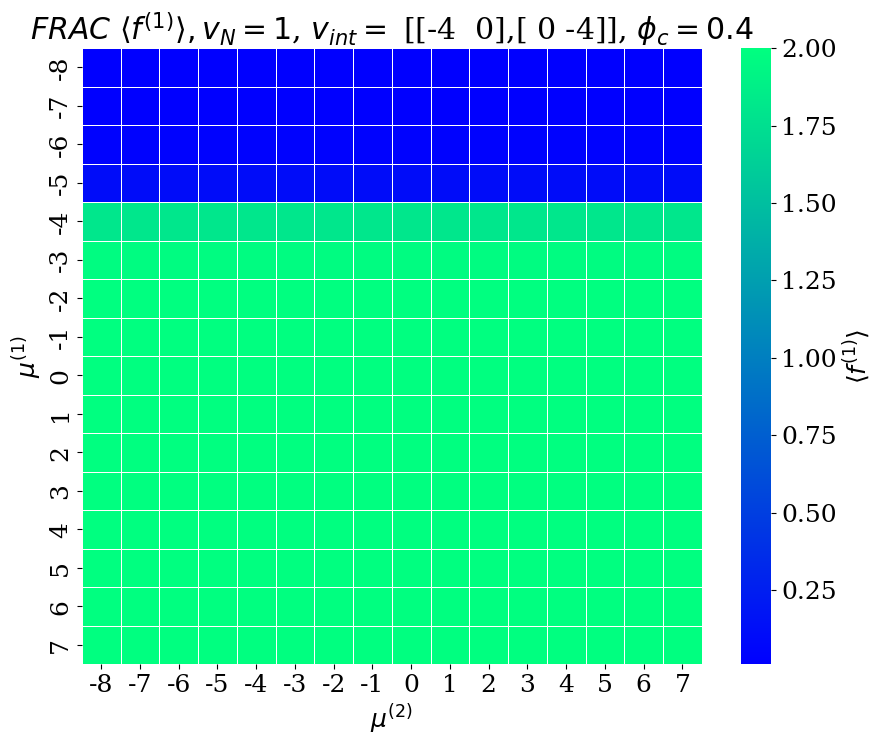

In [20]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

f_gam_soln_arr = f_gam_FAST_frac

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))

ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(r"$FRAC \  \langle f^{(1)} \rangle, v_{N} = %s$" % 1  \
          +  ", $ v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], " + r"$ \phi_c = %s$" % np.round(phi_c,5))

plt.show()


<Figure size 640x480 with 0 Axes>

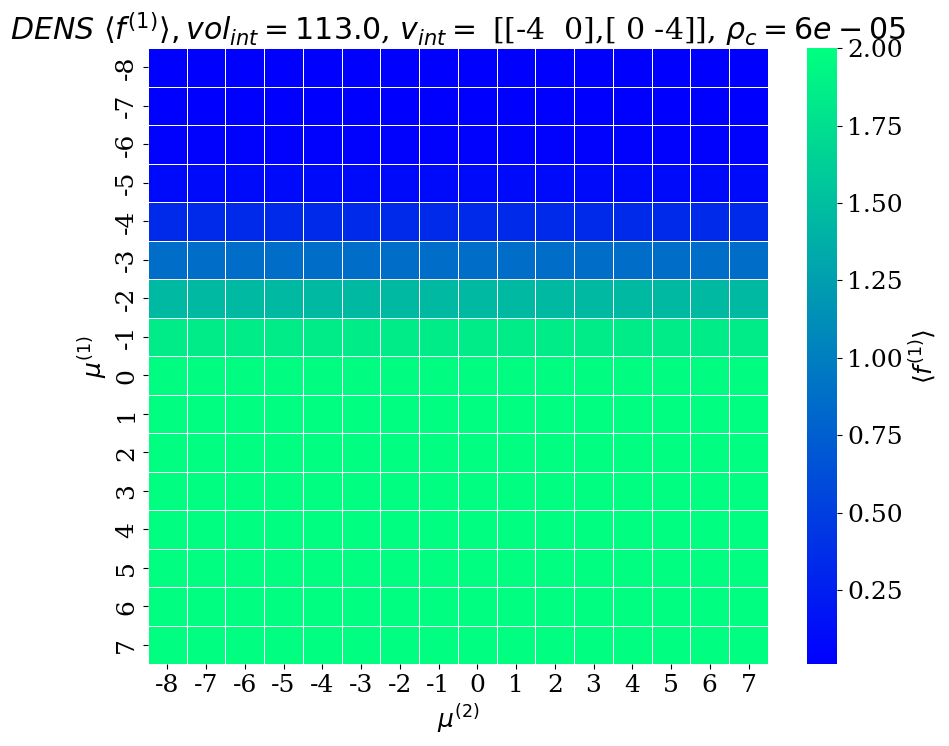

In [21]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

f_gam_soln_arr = f_gam_FAST_dens

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))

ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(r"$DENS \  \langle f^{(1)} \rangle, vol_{int} = %s$" % np.round(Vol_int,0)  \
          +  ", $ v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], " + r"$ \rho_c = %s$" % np.round(rho,5))

plt.show()


In [ ]:
print(r"$ \phi $")

In [ ]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

f_gam_soln_arr = f_gam_FAST

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))

ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(r"$ \langle f^{(1)} \rangle, v_N = %s$" % 1  \
          +  ", $ v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], " + r"$ \rho_c = %s$" % phi_c)

plt.show()


In [ ]:
# stabilty nala

In [23]:
%%time

s2_mat_shlk_frac = calc_sf_mats(chrom_frac, f_gam_FAST_frac, s_bind_FAST_frac, k_vec)

 I USING DATA TYPE <class 'numpy.float64'>
CPU times: total: 594 ms
Wall time: 2.07 s


In [24]:
# stab anal

# poly solv
# chi = 0.00083
# chi = 3/N
# chi = 2/N

# full soln
# chi = 0.00005828
chi = 0.


min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
# min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

s2_mats = s2_mat_shlk_frac

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
#         print("mu: ", mu)

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
        
#             S2_mat =  s2_mats[i][j][ik] # ORIGINAL

            S2_mat =  s2_mats[i][j][ik].copy()
#             print(S2_mat)
            S2_mat *= N*vol_nuc
            S2_mat[1][1] /= (N*vol_nuc)
            S2_mat[1][1] *= vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = S2_det
#             print("S2 det: ", S2_det)
#             print("---------------------------------------")
            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
    #             G2 = N* np.array([[S2_inv[0,0] - 2*chi/N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #                [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]/N, S2_inv[2,3] + v_int[0,1]/N],\
    #                [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]/N, S2_inv[3,3] + v_int[1,1]/N]])

#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL

                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

            # POLY/SOLV only
            S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

            if phi_c >= 0.999:
                raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)           
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

                val = G2[0]
#                 min_val = np.min(val)            
                min_eigval_arr_ps[i][j][ik] = val


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk[i][j] = minval_allk
            
            min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
            k_star_arr[i][j] = k_star

            
        min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
#         if len(min_vals_ps) != 0:
#             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
        min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

<Figure size 640x480 with 0 Axes>

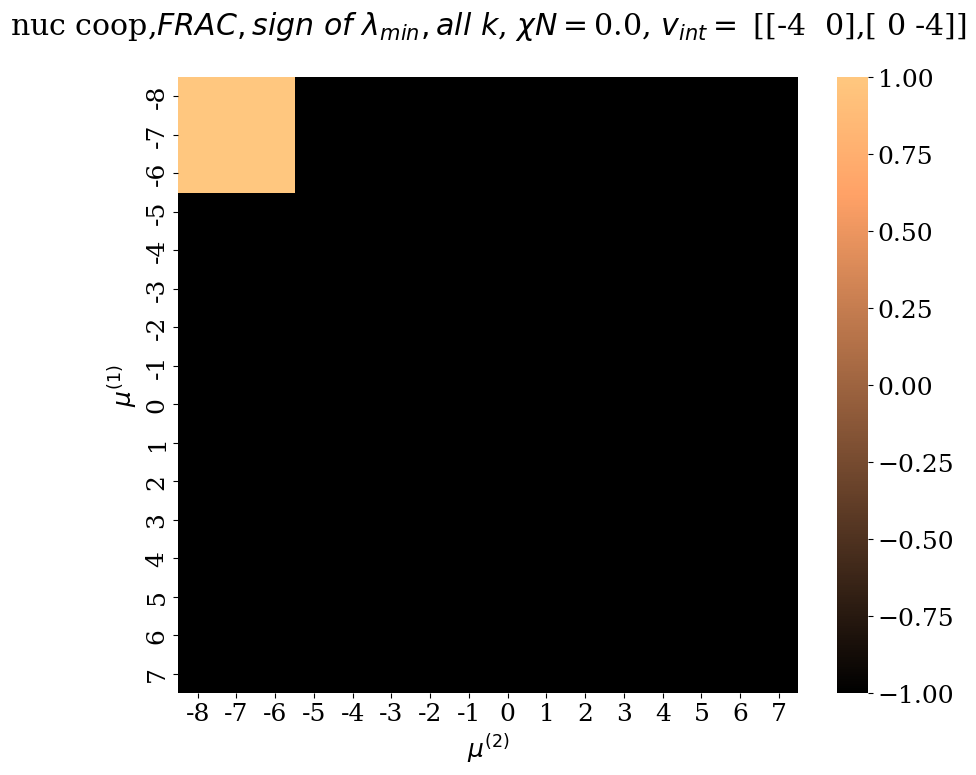

In [35]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk), linewidth=0., cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))


# ax.axvline(x=52, linewidth=4, color="w", linestyle = "--")
# ax.axhline(y=47, linewidth=4, color="w", linestyle = "--")

ax.axvline(x=47, linewidth=4, color="white", linestyle = "--")
ax.axhline(y=47, linewidth=4, color="white", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(looping + r"$ FRAC, sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


In [ ]:
N

In [29]:
%%time

s2_mat_shlk_dens = calc_sf_mats(chrom_dens, f_gam_FAST_dens, s_bind_FAST_dens, k_vec)

 I USING DATA TYPE <class 'numpy.float64'>
CPU times: total: 594 ms
Wall time: 2.2 s


In [31]:
# stab anal NUMBER DENSITY THEORY

# poly solv
# chi = 0.00083
# chi = 3/N
# chi = 2/N

# full soln
# chi = 0.00005828
chi = 0.


min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_DENS_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
# min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

s2_mats = s2_mat_shlk_dens

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
#         print("mu: ", mu)

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
        
#             S2_mat =  s2_mats[i][j][ik] # ORIGINAL

            S2_mat =  s2_mats[i][j][ik].copy()
#             print(S2_mat)
            M = len(marks_1)
            S2_mat *= M #N*vol_nuc
        
            S2_mat[1][1] = rho_s
            S2_mat[1][1] /= M #(N*vol_nuc)
            S2_mat[1][1] *= 1 #vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = S2_det
#             print("S2 det: ", S2_det)
#             print("---------------------------------------")
            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
    #             G2 = N* np.array([[S2_inv[0,0] - 2*chi/N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #                [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]/N, S2_inv[2,3] + v_int[0,1]/N],\
    #                [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]/N, S2_inv[3,3] + v_int[1,1]/N]])

#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL

                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int, S2_inv[2,3] + v_int[0,1]*Vol_int],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int, S2_inv[3,3] + v_int[1,1]*Vol_int]])
        
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

            # POLY/SOLV only
            S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

            if phi_c >= 0.999:
                raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)           
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

                val = G2[0]
#                 min_val = np.min(val)            
                min_eigval_arr_ps[i][j][ik] = val


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk_DENS[i][j] = minval_allk
            
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
            k_star_arr_DENS[i][j] = k_star

            
        min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
#         if len(min_vals_ps) != 0:
#             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
        min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_DENS_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

<Figure size 640x480 with 0 Axes>

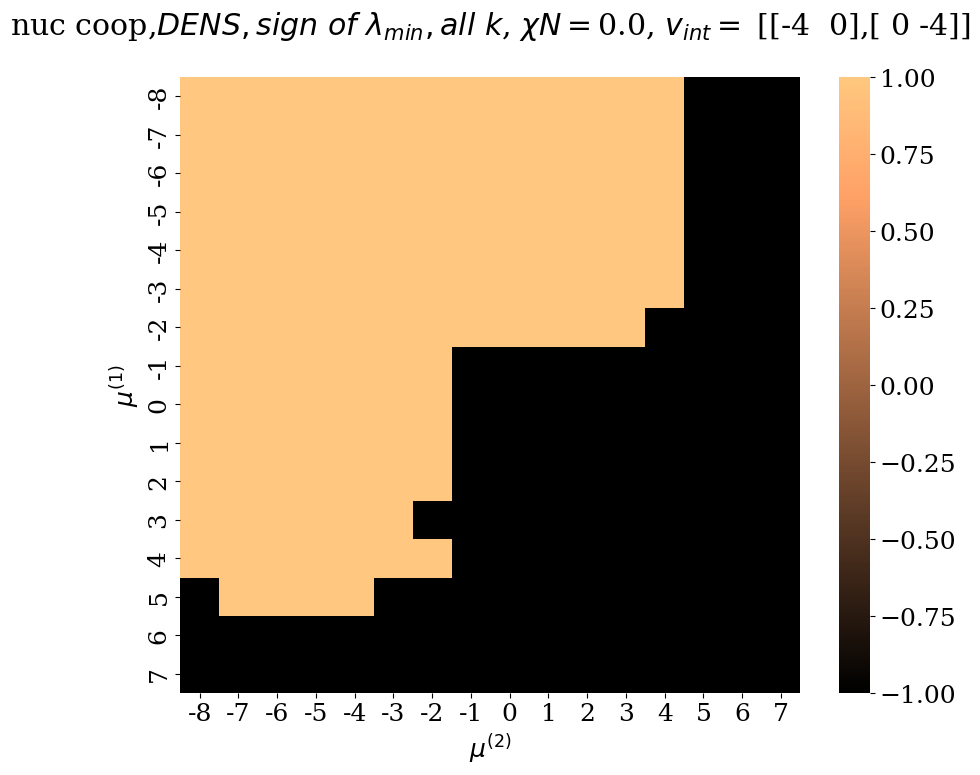

In [34]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk_DENS), linewidth=0., cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))


# ax.axvline(x=52, linewidth=4, color="w", linestyle = "--")
# ax.axhline(y=47, linewidth=4, color="w", linestyle = "--")

ax.axvline(x=47, linewidth=4, color="white", linestyle = "--")
ax.axhline(y=47, linewidth=4, color="white", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(looping + r"$DENS, sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

# from chromo_vertex_nuclear_density import *
# from chromo_vertex_nuclear_competitive_2_density import *
from chromo_vertex_nuclear_density_corrected import *


In [2]:
# %%time

# start = time.time()

mu_max = 8#-2.99 #10
mu_min = -8
del_mu = 1#0.25

# mu_max = -4.399#np.nan
# mu_min = -4.411#-9#np.nan
# del_mu = .001#np.nan

#mu_max = 10
#mu_min = -10
#del_mu = 1 #0.25

klog_min = -2.5
klog_max = -1
klog_num = 30


n_bind = 2 #types of proteins/marks


chi = None
e_m = np.array([-1.5, -1.5]) #binding energy

#v_int =  np.array([[-3.92, 3], [3, -3.92]])
v_int =  np.array([[-4, 4], [4, -4]])
# v_int =  np.array([[0, 0], [0, 0]])

# v_int = np.array([[-3.92,0],[0,-3.92]]) # protein-protein interaction param
# v_int = np.array([[0,3.92],[3.92,0]]) # protein-protein interaction param
# v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param

# REALLY RHO
rho_c = (3e7)  /  ((4/3) * np.pi*  (5)**3 * (1000/1)**3) # nucleosomes per nm^3

avo = 6.02e23
water_molmas = 18
rho_s = avo * (1/water_molmas) * (1000  *(1000/1) * (1/1e9)**3)#  num / nm^3

chrom_type = "DNA"
# marks_1 = np.loadtxt(r"H3K9me3_ENCFF651ZTT_Chr_22_trimmed.txt").astype(np.uint8)
# marks_2 = np.loadtxt(r"H3K27me3_ENCFF470ECE_Chr_22_trimmed.txt").astype(np.uint8)
marks_1 = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\HNCFF683HCZ_H3K9me3_methyl.txt").astype(np.uint8)
marks_2 = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ENCFF919DOR_H3K27me3_methyl.txt").astype(np.uint8)


# chrom_type = "test" #"DNA"  # test if 6 nucleosomes, DNA if using joes chromosome
# marks_1 = [0,2,1,0,2,1] # marks for protein 1
# marks_2 = [1,1,1,0,2,2] # marks for protein 2

# marks_1 = [2,2,2,0,0,0] # marks for protein 1
# marks_2 = [0,0,0,1,1,2] # marks for protein 2

poly_marks = [marks_1, marks_2]

chrom_dens = def_chrom(n_bind, v_int, e_m, rho_c, rho_s, poly_marks, mu_max, mu_min, del_mu, chrom_type)

[n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom_dens

k_vec = np.logspace(klog_min, klog_max, klog_num) / (b)


mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

spacing = int(1 / del_mu)

# ID = -100 + np.sum(e_m) + np.sum(v_int) + phi_c + mu_max + mu_min + del_mu + klog_min + klog_max + klog_num//5 # for nuclear/looping AND competitive
# ID = np.round(ID, 5)





In [3]:

# def calc_binding_states(chrom):
#     # calculate f_gam and s_bind for each protein type, at each mu given
#     # KEY RETURNS: f_gam_soln_arr, list of matrices of self-consistent f_gammas (for protein 1 and 2) at each mu1, mu2
#     #              s_bind_soln_arr, list of matrices of s_binds at each mu1, mu2
#     #TODO: 
#     #  - deal with interpolating to find more precise zero crossing
#     print("JUPYYY VERSIONNNN")
#     [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
#     mu1_array = np.arange(mu_min, mu_max, del_mu)#[-5]
#     mu2_array = np.arange(mu_min, mu_max, del_mu)#[-5]
#     f_gam_arr = np.arange(-0.001,2.002,0.001)
#     f_gam_arr = np.arange(-0.01,2.02,0.01)

#     f_gam_soln_arr = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

#     s_bind_soln_arr = np.zeros((n_bind*3, len(mu1_array), len(mu2_array)))

#     f_gam_soln_arr_max = np.zeros((n_bind, len(mu1_array), len(mu2_array)))
#     f_gam_soln_arr_min = np.zeros((n_bind, len(mu1_array), len(mu2_array)))

#     multi_soln_mus = np.zeros((len(mu1_array), len(mu2_array)))
    
# #     #1)
# #     phi_bind_arr = np.zeros(len(f_gam_arr))
# #     phi_bind_arr = rho_c * f_gam_arr

# #     f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
# #     combined_matrix = np.dstack((f1*rho_c, f2*rho_c))#.tolist()
# # #         erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair
# # #     erg_int = np.einsum('ijk,kl->jil', combined_matrix, v_int*v_N)  # this is the mat mul of each fgamma pair
# #     erg_int = np.einsum('ijk,kl->jil', combined_matrix, v_int*Vol_int)  # this is the mat mul of each fgamma pair

# #     erg_ints = np.split(erg_int, n_bind, axis=2)
# #     for i in range(len(erg_ints)):
# #         erg_ints[i] = np.squeeze(erg_ints[i])

#     #2)
# #     X, Y = np.meshgrid(f_gam_arr, f_gam_arr)
    
#     for k, mu1 in enumerate(mu1_array):
#         for l, mu2 in enumerate(mu2_array):
#             mu = [mu1, mu2]


#             # 1) generate right hand side (RHS) of f_gamma1 and f_gamma2 as 2d matrices ( [f1, f2] )


#             phi_bind_arr = np.zeros(len(f_gam_arr))
#             phi_bind_arr = rho_c * f_gam_arr

#             RHS = np.zeros(len(f_gam_arr))
#             RHS_arr = np.zeros((n_bind, len(f_gam_arr),len(f_gam_arr)))

#             f1,f2 = np.meshgrid(f_gam_arr,f_gam_arr)
#             combined_matrix = np.dstack((f1*rho_c, f2*rho_c))#.tolist()
# #             erg_int = np.einsum('kl,ijk->jil', v_int, combined_matrix)  #WORKS this is the mat mul of each fgamma pair
#             erg_int = np.einsum('ijk,kl->jil', combined_matrix, v_int*Vol_int)  # this is the mat mul of each fgamma pair

#             erg_ints = np.split(erg_int, n_bind, axis=2)
#             for i in range(len(erg_ints)):
#                 erg_ints[i] = np.squeeze(erg_ints[i])

#             for mark in range(n_bind): # for each reader protein/ mark type
#                 for om in range(3): 
#                     f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
#                     f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
#                     q = 1 + np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])

#                     RHS = RHS_arr[mark] 

#                     RHS += f_om[om+(mark*3)] * (np.exp(mu[mark] - f_bind_1 - erg_ints[mark]) + 
#                                                  2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_ints[mark])) / q 
#                     RHS_arr[mark] = RHS




#             # 2) self-consistently solve for fgamma1 and fgamma2, finding where the difference (fgamma-RHS) crosses zero



#             X, Y = np.meshgrid(f_gam_arr, f_gam_arr)

#             crs1 = find_zero_crossings(RHS_arr[0]-Y)
#             crs2 = find_zero_crossings(RHS_arr[1]-X)



#             # 3) find the intersection of the sets of fgamma_n solutions, such that both f_gammas are self consistent



#             aset = set([tuple(x) for x in crs1])
#             bset = set([tuple(x) for x in crs2])
#             inds = np.array([x for x in aset & bset])+1

#             f_gam_solns = np.zeros(len(inds), dtype = "object")#f_gam_arr[inds[0]]
            
            
#             # 3b) compare saddle point free energies if there are multiple solutions
#             min_E_soln = [None]*n_bind
#             min_E = None
#             for i in range(len(inds)):

#                 #original solution
#                 soln = f_gam_arr[inds[i]]           
#                 f_gam_solns[i] = soln

#                 if len(inds) == 1:
#                     min_E_soln = soln
#                 else:
#                     E_soln = calc_saddle_point_E(soln, mu, chrom)
#                     if min_E == None:
#                         min_E_soln = soln
#                         min_E = E_soln
#                     else:
#                         if E_soln < min_E:
#                             min_E_soln = soln
#                             min_E = E_soln

#             multi_soln = False
#             if len(f_gam_solns) > 1:
#                 multi_soln_mus[k,l] = 1 # noting all mus where there are multiple f_bar solns

#             f_gam_solns = [min_E_soln] # selecting minimum E solution

            

#             # 4) for each f_gamma solution pair, calculate each individual s_bind (omega = 0-2)



#             sbind = np.zeros((len(f_gam_solns), n_bind*3))

#             for j, f_gam_soln in enumerate(f_gam_solns):
#                 phi_bind_arr = rho_c * np.array(f_gam_soln)
#     #             erg_int = np.matmul(v_int, phi_bind_arr)
#                 erg_int = np.matmul(phi_bind_arr, v_int*Vol_int)

#                 ind = 0
#                 for mark in range(n_bind): # for each reader protein/ mark type
#                     for om in range(3): # for each possible number of marked tails on nucl
#                         f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
#                         f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
#                         q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])

#                         sbind[j, om+mark*3] =  (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                                      2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q 
#                         ind+=1    
#                     ind0 = mark * 3 
#                     f_gam_orig = f_gam_solns[j][mark]
#                     f_gam_calc = np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)])
#                     if f_gam_calc + 0.02 < f_gam_orig or f_gam_calc - 0.02 > f_gam_orig:
#                         print("FAILED self-consistency")
#                         print("mu: ", mu)
#                         print(np.sum(f_om[ind0:(ind0 + 3)] * sbind[j][ind0:(ind0 + 3)]))
#                         print(f_gam_solns[j][mark])
#                         raise Excpetion("failed self-consistency")

#             # 4) store results in array

#             if multi_soln:
#                 raise Exception("not implemented")
#                 for f_gam_soln in f_gam_solns:
#                     for mark in range(n_bind):
#                         f_gam_soln_arr_max[mark][k][l] = ""
#             else:
#                 for mark in range(n_bind): 
#                     f_gam_soln_arr[mark][k][l] = f_gam_solns[0][mark]
#                     for om in range(3):
#                         s_bind_soln_arr[om+mark*3][k][l] = sbind[0,om+mark*3]
#     return f_gam_soln_arr, s_bind_soln_arr

In [4]:
rho_s

33.44444444444445

In [5]:
-3002 + np.sum(e_m) + np.sum(v_int)  + mu_max + mu_min + del_mu + klog_min + klog_max + klog_num//5

-3001.5

In [6]:
%%time
f_gam_FAST_dens, s_bind_FAST_dens = calc_binding_states(chrom_dens)

CPU times: total: 15.1 s
Wall time: 29 s


In [22]:
%%time

s2_mat_shlk_dens = calc_sf_mats(chrom_dens, f_gam_FAST_dens, s_bind_FAST_dens, k_vec)

 I USING DATA TYPE <class 'numpy.float64'>
CPU times: total: 1.14 s
Wall time: 1.57 s


<Figure size 640x480 with 0 Axes>

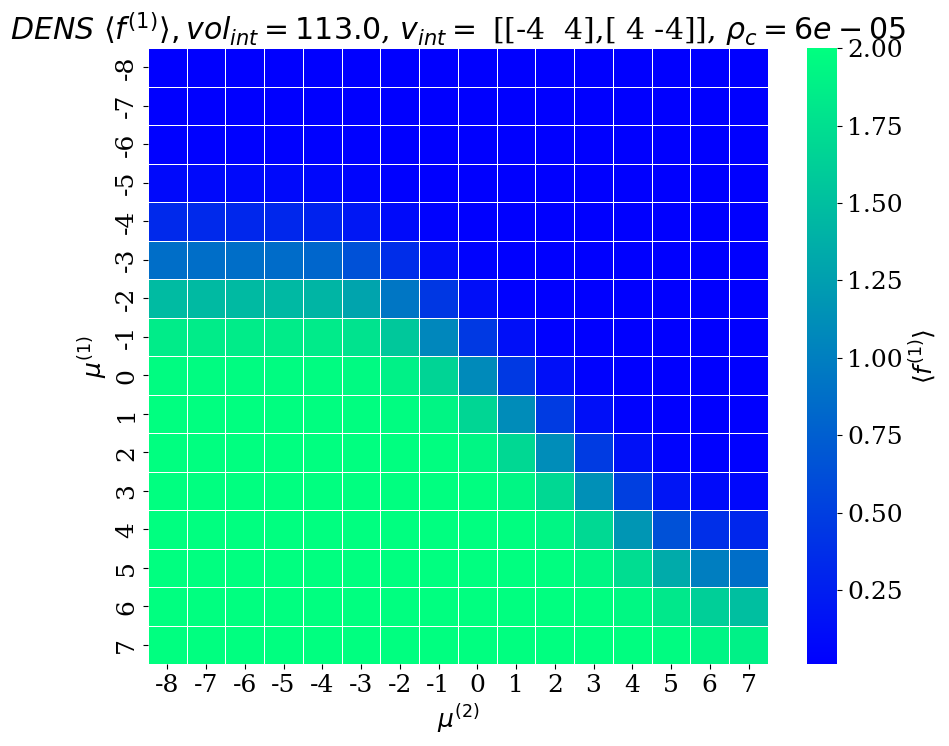

In [7]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

f_gam_soln_arr = f_gam_FAST_dens

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))

ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(r"$DENS \  \langle f^{(1)} \rangle, vol_{int} = %s$" % np.round(Vol_int,0)  \
          +  ", $ v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], " + r"$ \rho_c = %s$" % np.round(rho_c,5))

plt.show()


<Figure size 640x480 with 0 Axes>

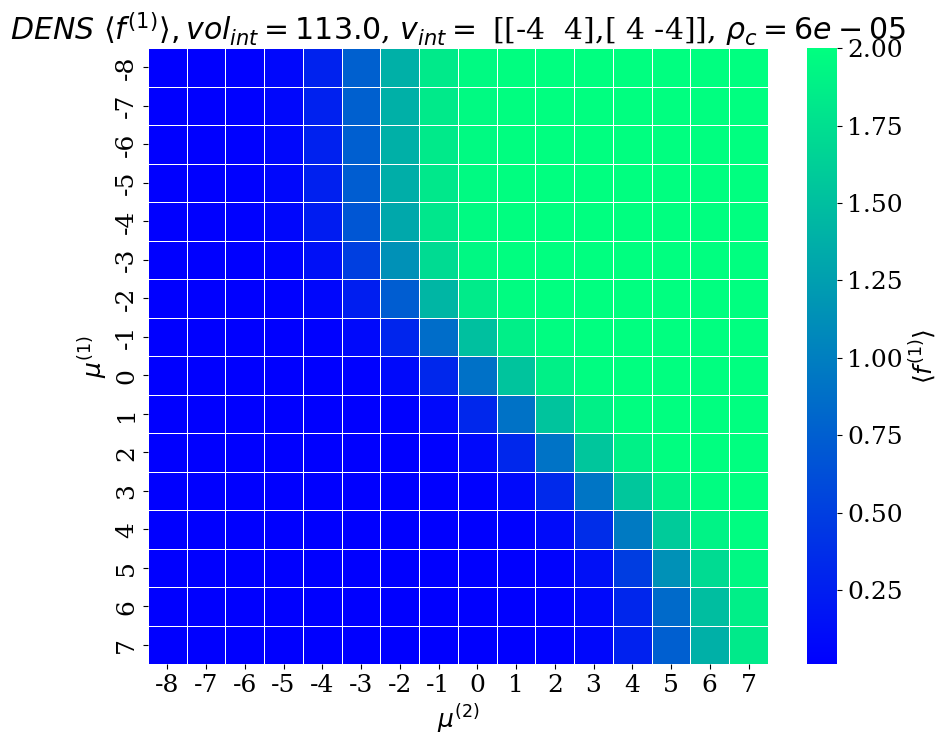

In [8]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

f_gam_soln_arr = f_gam_FAST_dens

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))

ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(r"$DENS \  \langle f^{(1)} \rangle, vol_{int} = %s$" % np.round(Vol_int,0)  \
          +  ", $ v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], " + r"$ \rho_c = %s$" % np.round(rho_c,5))

plt.show()


<Figure size 640x480 with 0 Axes>

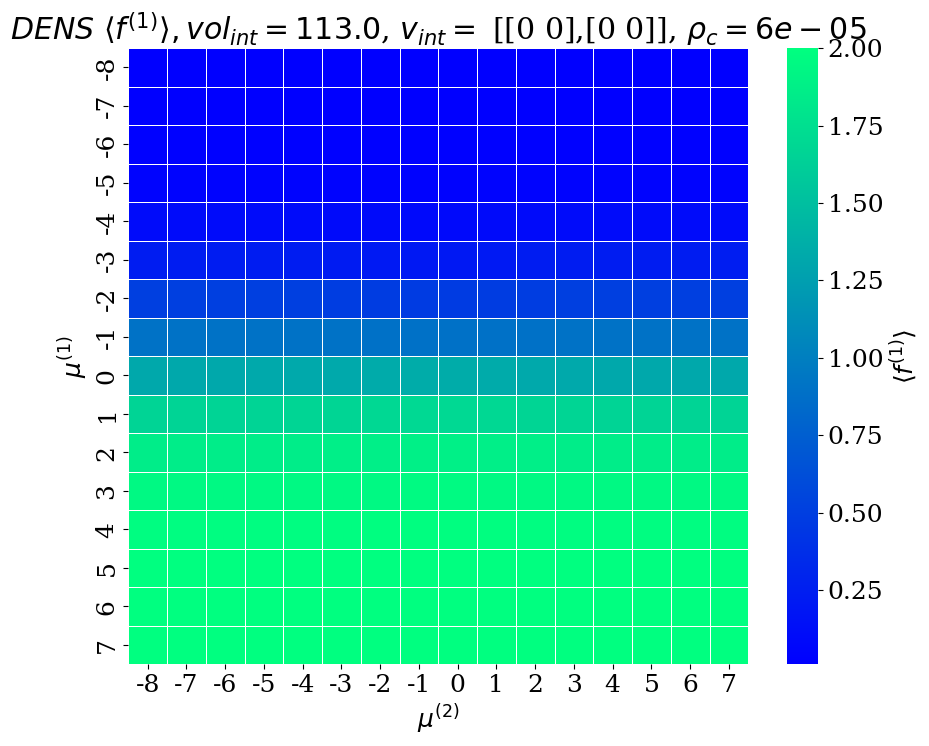

In [7]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

f_gam_soln_arr = f_gam_FAST_dens

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))

ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(r"$DENS \  \langle f^{(1)} \rangle, vol_{int} = %s$" % np.round(Vol_int,0)  \
          +  ", $ v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], " + r"$ \rho_c = %s$" % np.round(rho_c,5))

plt.show()


<Figure size 640x480 with 0 Axes>

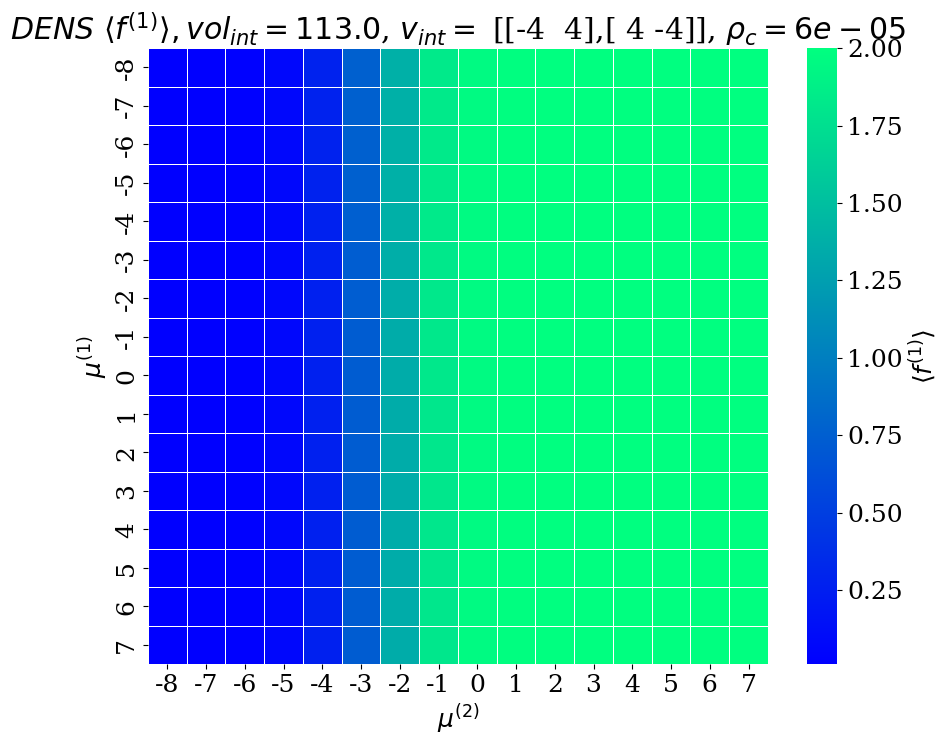

In [7]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

f_gam_soln_arr = f_gam_FAST_dens

# #protein 1
ax = sns.heatmap(f_gam_soln_arr[1], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))

ax.axhline(y=47, linewidth=4, color="black", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(r"$DENS \  \langle f^{(1)} \rangle, vol_{int} = %s$" % np.round(Vol_int,0)  \
          +  ", $ v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], " + r"$ \rho_c = %s$" % np.round(rho_c,5))

plt.show()


In [11]:
# stab anal NUMBER DENSITY THEORY from import

# poly solv
# chi = 0.00083
# chi = 3/N
# chi = 2/N

# full soln
# chi = 0.00005828
chi = 0.


min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_DENS_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
# min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

s2_mats = s2_mat_shlk_dens

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
#         print("mu: ", mu)

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])
        
#             S2_mat =  s2_mats[i][j][ik] # ORIGINAL

            S2_mat =  s2_mats[i][j][ik].copy()
#             print(S2_mat)
            M = len(marks_1)
            S2_mat *= M #N*vol_nuc
        
#             S2_mat[1][1] = rho_s
            S2_mat[1][1] /= M #(N*vol_nuc)
            S2_mat[1][1] *= 1 #vol_solv

#             if phi_c >= 0.999:
#                 raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = S2_det
#             print("S2 det: ", S2_det)
#             print("---------------------------------------")
            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
    #             G2 = N* np.array([[S2_inv[0,0] - 2*chi/N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #                [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]/N, S2_inv[2,3] + v_int[0,1]/N],\
    #                [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]/N, S2_inv[3,3] + v_int[1,1]/N]])

#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL

                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int, S2_inv[2,3] + v_int[0,1]*Vol_int],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int, S2_inv[3,3] + v_int[1,1]*Vol_int]])
        
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

            # POLY/SOLV only
            S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

#             if phi_c >= 0.999:
#                 raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)           
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

                val = G2[0]
#                 min_val = np.min(val)            
                min_eigval_arr_ps[i][j][ik] = val


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk_DENS[i][j] = minval_allk
            
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
            k_star_arr_DENS[i][j] = k_star

            
        min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
#         if len(min_vals_ps) != 0:
#             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
        min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_DENS_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

<Figure size 640x480 with 0 Axes>

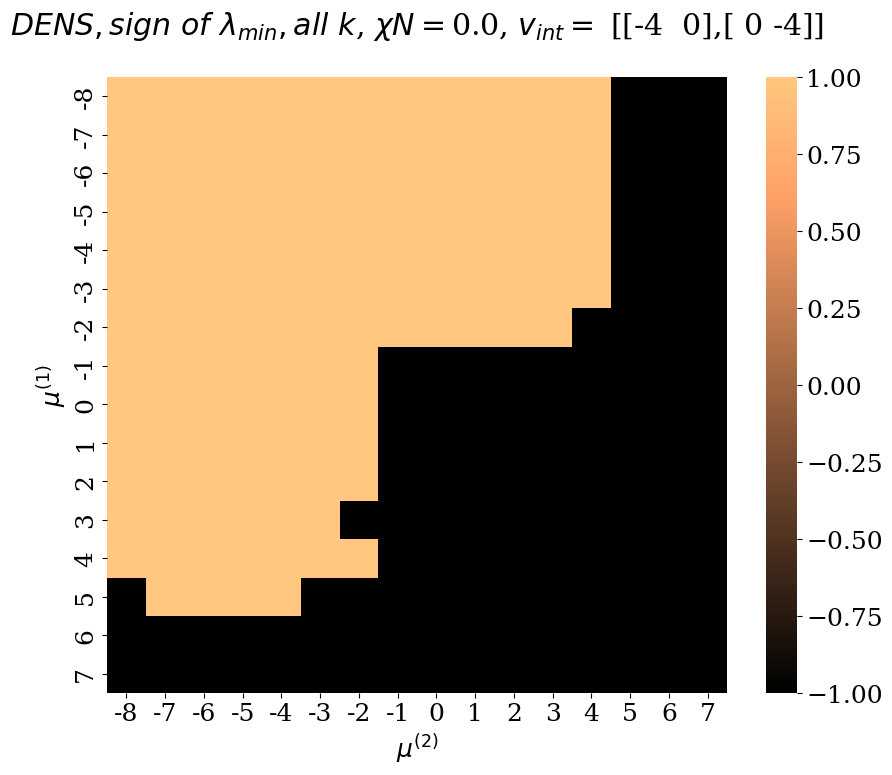

In [13]:
#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
ax = sns.heatmap(np.sign(min_eigval_arr_allk_DENS), linewidth=0., cmap = "copper", xticklabels=mu2_array, yticklabels=mu1_array)
# ax = sns.heatmap(np.sign(min_eigval_arr[0:3][0:3][k_ind]), linewidth=0.1, cmap = "winter", cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
# protein 1
# ax = sns.heatmap(f_gam_soln_arr[0], linewidth=0.5, cmap = "winter", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r'$ \langle f^{(1)} \rangle $'})
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))


# ax.axvline(x=52, linewidth=4, color="w", linestyle = "--")
# ax.axhline(y=47, linewidth=4, color="w", linestyle = "--")

ax.axvline(x=47, linewidth=4, color="white", linestyle = "--")
ax.axhline(y=47, linewidth=4, color="white", linestyle = "--")

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"$DENS, sign \ of \ \lambda_{min}, all \ k$" +  ", $\chi N = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]"+\
          "\n")


plt.show()


In [16]:

def eval_f_bind_cooperative(n_b_arr, n_m_pair, e_m_arr,\
                        j_int_g1g1, j_int_g1g2, j_int_g2g2):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0
    n_m1 = n_m_pair[0]
    n_m2 = n_m_pair[1]
    
    if n_m1 == n_m2:
        n_m = n_m1
        
        if n_b_arr==[0,0]:
            f_bind = 0
        elif n_b_arr==[1,0]:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(np.exp(-e_m_arr[0]) + 1)
            elif n_m == 2:
                f_bind = -np.log(2) + e_m_arr[0]
        elif n_b_arr==[0,1]:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(np.exp(-e_m_arr[1]) + 1)
            elif n_m == 2:
                f_bind = -np.log(2) + e_m_arr[1]
        elif n_b_arr==[1,1]:
            if n_m == 0:
                f_bind = -np.log(2)+j_int_g1g2
            elif n_m == 1:
                f_bind = -np.log(np.exp(-e_m_arr[0]) + np.exp(-e_m_arr[1]))+j_int_g1g2
            elif n_m == 2:
                f_bind = -np.log(2) + e_m_arr[0] + e_m_arr[1]+j_int_g1g2
        elif n_b_arr==[2,0]:
            if n_m == 0:
                f_bind = 0+j_int_g1g1
            elif n_m == 1:
                f_bind = e_m_arr[0]+j_int_g1g1
            elif n_m == 2:
                f_bind = 2*e_m_arr[0]+j_int_g1g1
        elif n_b_arr==[0,2]:
            if n_m == 0:
                f_bind = 0+j_int_g2g2
            elif n_m == 1:
                f_bind = e_m_arr[1]+j_int_g2g2
            elif n_m == 2:
                f_bind = 2*e_m_arr[1]+j_int_g2g2
        elif n_b_arr==[1,2]:
            if n_m == 0:
                f_bind = 0+2*j_int_g1g2 +  -np.log(2)
            elif n_m == 1:
                f_bind = e_m_arr[1]+2*j_int_g1g2 + -np.log(np.exp(-e_m_arr[0]) + 1)
            elif n_m == 2:
                f_bind = 2*e_m_arr[1]+2*j_int_g1g2 + -np.log(2) + e_m_arr[0]
        elif n_b_arr==[2,1]:
            if n_m == 0:
                f_bind = 0+j_int_g1g1  -np.log(2)
            elif n_m == 1:
                f_bind = e_m_arr[0]+j_int_g1g1 -np.log(np.exp(-e_m_arr[1]) + 1)
            elif n_m == 2:
                f_bind = 2*e_m_arr[0]+j_int_g1g1  -np.log(2) + e_m_arr[1]
        elif n_b_arr==[2,2]:
            if n_m == 0:
                f_bind = 0+j_int_g1g1 + 0+j_int_g2g2
            elif n_m == 1:
                f_bind = e_m_arr[0]+j_int_g1g1 +  e_m_arr[1]+j_int_g2g2
            elif n_m == 2:
                f_bind = 2*e_m_arr[0]+j_int_g1g1 + 2*e_m_arr[1]+j_int_g2g2        
                
    elif n_m1 == 1 and n_m2 == 0:
        if n_b_arr==[0,0]:
            f_bind = 0
        elif n_b_arr==[1,0]:
            f_bind = -np.log(np.exp(-e_m_arr[0]) + 1)
        elif n_b_arr==[0,1]:
            f_bind = -np.log(2)
        elif n_b_arr==[1,1]:
            f_bind = -np.log(np.exp(-e_m_arr[0]) + 1) +j_int_g1g2
        elif n_b_arr==[2,0]:
            f_bind = e_m_arr[0]+j_int_g1g1
        elif n_b_arr==[0,2]:
            f_bind = 0+j_int_g2g2
        elif n_b_arr==[1,2]:
            f_bind = 0+j_int_g2g2 +  -np.log(np.exp(-e_m_arr[0]) + 1)
        elif n_b_arr==[2,1]:
            f_bind = e_m_arr[0]+j_int_g1g1 -np.log(2)
        elif n_b_arr==[2,2]:
            f_bind = e_m_arr[0]+j_int_g1g1 +j_int_g2g2 
    elif n_m1 == 0 and n_m2 == 1:
        if n_b_arr==[0,0]:
            f_bind = 0
        elif n_b_arr==[0,1]:
            f_bind = -np.log(np.exp(-e_m_arr[1]) + 1)
        elif n_b_arr==[1,0]:
            f_bind = -np.log(2)
        elif n_b_arr==[1,1]:
            f_bind = -np.log(np.exp(-e_m_arr[1]) + 1) +j_int_g1g2
        elif n_b_arr==[0,2]:
            f_bind = e_m_arr[1]+j_int_g2g2
        elif n_b_arr==[2,0]:
            f_bind = 0+j_int_g1g1
        elif n_b_arr==[1,2]:
            f_bind = e_m_arr[1]+j_int_g2g2 -np.log(2)
        elif n_b_arr==[2,1]:
            f_bind = 0+j_int_g1g1 -np.log(np.exp(-e_m_arr[1]) + 1)
        elif n_b_arr==[2,2]:
            f_bind = e_m_arr[1]+j_int_g1g1 +j_int_g2g2
            
    elif n_m1 == 2 and n_m2 == 0:
        if n_b_arr==[0,0]:
            f_bind = 0
        elif n_b_arr==[1,0]:
            f_bind = -np.log(2) + e_m_arr[0]
        elif n_b_arr==[0,1]:
            f_bind = -np.log(2)
        elif n_b_arr==[1,1]:
            f_bind = -np.log(2) + e_m_arr[0] +j_int_g1g2
        elif n_b_arr==[2,0]:
            f_bind = 2*e_m_arr[0]+j_int_g1g1
        elif n_b_arr==[0,2]:
            f_bind = 0+j_int_g2g2
        elif n_b_arr==[1,2]:
            f_bind = -np.log(2) + e_m_arr[0]+j_int_g2g2
        elif n_b_arr==[2,1]:
            f_bind = 2*e_m_arr[0]+j_int_g1g1 -np.log(2)
        elif n_b_arr==[2,2]:
            f_bind = 2*e_m_arr[0]+j_int_g1g1 +j_int_g2g2
    elif n_m1 == 0 and n_m2 == 2:
        if n_b_arr==[0,0]:
            f_bind = 0
        elif n_b_arr==[0,1]:
            f_bind = -np.log(2) + e_m_arr[1]
        elif n_b_arr==[1,0]:
            f_bind = -np.log(2)
        elif n_b_arr==[1,1]:
            f_bind = -np.log(2) + e_m_arr[1] +j_int_g1g2
        elif n_b_arr==[0,2]:
            f_bind = 2*e_m_arr[1]+j_int_g2g2
        elif n_b_arr==[2,0]:
            f_bind = 0+j_int_g1g1
        elif n_b_arr==[2,1]:
            f_bind = -np.log(2) + e_m_arr[1]+j_int_g1g1
        elif n_b_arr==[1,2]:
            f_bind = 2*e_m_arr[1]+j_int_g2g2 -np.log(2)
        elif n_b_arr==[2,2]:
            f_bind = 2*e_m_arr[1]+j_int_g2g2 +j_int_g1g1  
            
    elif n_m1 == 2 and n_m2 == 1:
        if n_b_arr==[0,0]:
            f_bind = 0
        elif n_b_arr==[1,0]:
            f_bind = -np.log(2) + e_m_arr[0]
        elif n_b_arr==[0,1]:
            f_bind = -np.log(np.exp(-e_m_arr[1]) + 1)
        elif n_b_arr==[1,1]:
            f_bind = -np.log(np.exp(-e_m_arr[0]) + np.exp(-e_m_arr[0] + -e_m_arr[1])) +j_int_g1g2
        elif n_b_arr==[2,0]:
            f_bind = 2*e_m_arr[0]+j_int_g1g1
        elif n_b_arr==[0,2]:
            f_bind =  e_m_arr[1]+j_int_g2g2
        elif n_b_arr==[2,1]:
            f_bind = 2*e_m_arr[0]+j_int_g1g1 + -np.log(np.exp(-e_m_arr[1]) + 1)
        elif n_b_arr==[1,2]:
            f_bind =  e_m_arr[1]+j_int_g2g2 -np.log(2) + e_m_arr[0]
        elif n_b_arr==[2,2]:
            f_bind =    e_m_arr[1]+j_int_g2g2 + 2*e_m_arr[0]+j_int_g1g1  
    elif n_m1 == 1 and n_m2 == 2:
        if n_b_arr==[0,0]:
            f_bind = 0
        elif n_b_arr==[0,1]:
            f_bind = -np.log(2) + e_m_arr[1]
        elif n_b_arr==[1,0]:
            f_bind = -np.log(np.exp(-e_m_arr[0]) + 1)
        elif n_b_arr==[1,1]:
            f_bind = -np.log(np.exp(-e_m_arr[1]) + np.exp(-e_m_arr[1] + -e_m_arr[0])) +j_int_g1g2
        elif n_b_arr==[0,2]:
            f_bind = 2*e_m_arr[1]+j_int_g2g2
        elif n_b_arr==[2,0]:
            f_bind =  e_m_arr[0]+j_int_g1g1
        elif n_b_arr==[1,2]:
            f_bind = 2*e_m_arr[1]+j_int_g2g2 + -np.log(np.exp(-e_m_arr[0]) + 1)
        elif n_b_arr==[2,1]:
            f_bind =  e_m_arr[0]+j_int_g1g1 -np.log(2) + e_m_arr[1]
        elif n_b_arr==[2,2]:
            f_bind =    e_m_arr[0]+j_int_g1g1 + 2*e_m_arr[1]+j_int_g2g2    
    return f_bind

In [ ]:
(n_b_arr, n_m_pair, e_m_arr,j_int_g1g1, j_int_g1g2, j_int_g2g2) = ([2,1], [1,1])
eval_f_bind_cooperative(n_b_arr, n_m_pair, e_m_arr,\
                        j_int_g1g1, j_int_g1g2, j_int_g2g2):